In [1]:
# Import Libraries and Load Excel File
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from google.colab import files
uploaded = files.upload()

# Load the Excel file
data = pd.read_excel('flight_price.xlsx')

# View the data
data.head()


Saving flight_price.xlsx to flight_price.xlsx


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [2]:
# Basic overview
print(data.shape)
print(data.columns)
print(data.info())

# Check for missing values
data.isnull().sum()

# Drop rows with missing values for simplicity
data_clean = data.dropna().copy()


(10683, 11)
Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
None


In [3]:
# Convert date/time columns
data_clean['Journey_Date'] = pd.to_datetime(data_clean['Date_of_Journey'])
data_clean['Journey_Day'] = data_clean['Journey_Date'].dt.day
data_clean['Journey_Month'] = data_clean['Journey_Date'].dt.month

data_clean['Departure_Timestamp'] = pd.to_datetime(data_clean['Dep_Time'])
data_clean['Dep_Hour'] = data_clean['Departure_Timestamp'].dt.hour
data_clean['Dep_Min'] = data_clean['Departure_Timestamp'].dt.minute

data_clean['Arrival_Timestamp'] = pd.to_datetime(data_clean['Arrival_Time'])
data_clean['Arr_Hour'] = data_clean['Arrival_Timestamp'].dt.hour
data_clean['Arr_Min'] = data_clean['Arrival_Timestamp'].dt.minute

# Convert Duration to minutes
def duration_to_minutes(x):
    time = x.strip().split()
    mins = 0
    for part in time:
        if 'h' in part:
            mins += int(part.replace('h','')) * 60
        elif 'm' in part:
            mins += int(part.replace('m',''))
    return mins

data_clean['Duration_Minutes'] = data_clean['Duration'].apply(duration_to_minutes)

# Handle categorical variables
data_clean['Total_Stops'] = data_clean['Total_Stops'].replace({
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
}).astype(int)

# Label encode string columns
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for col in ['Airline', 'Source', 'Destination', 'Route', 'Additional_Info']:
    data_clean[col] = label.fit_transform(data_clean[col])


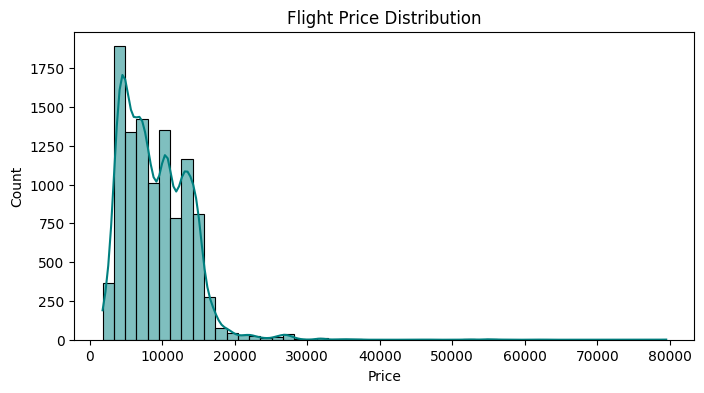

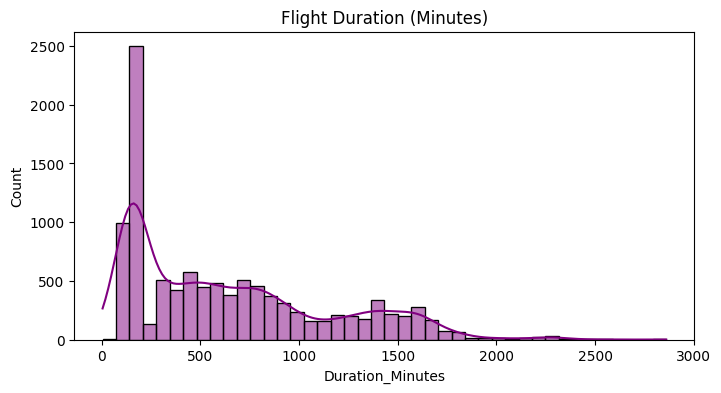

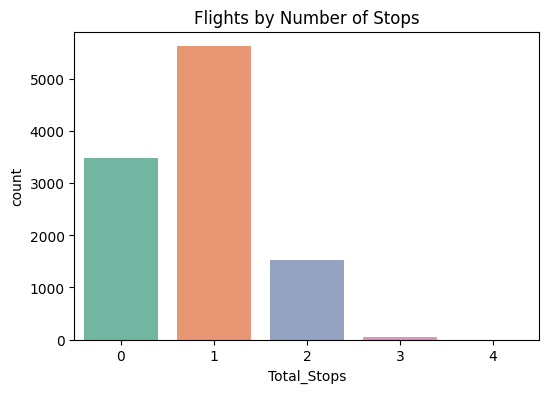

In [4]:
# Distribution of Prices
plt.figure(figsize=(8,4))
sns.histplot(data_clean['Price'], color='teal', bins=50, kde=True)
plt.title("Flight Price Distribution")
plt.show()

# Duration distribution
plt.figure(figsize=(8,4))
sns.histplot(data_clean['Duration_Minutes'], color='purple', kde=True)
plt.title("Flight Duration (Minutes)")
plt.show()

# Total Stops
plt.figure(figsize=(6,4))
sns.countplot(x='Total_Stops', data=data_clean, palette='Set2')
plt.title("Flights by Number of Stops")
plt.show()


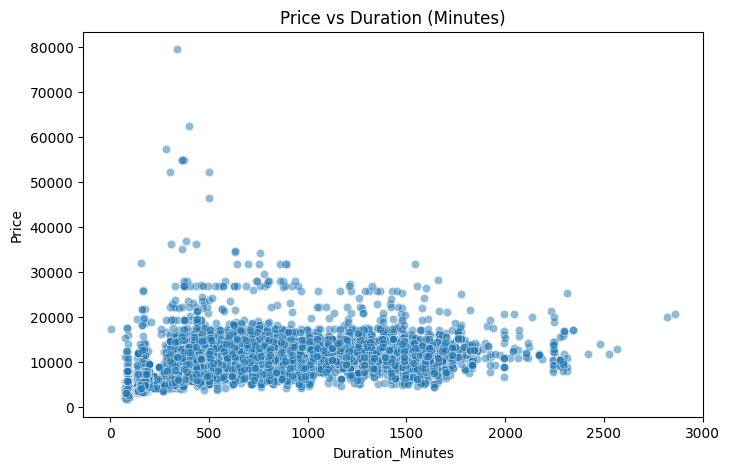

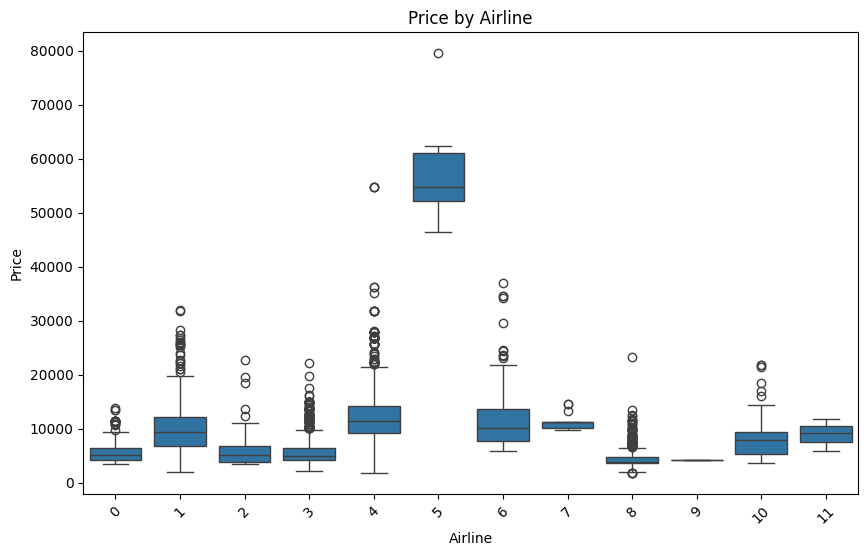

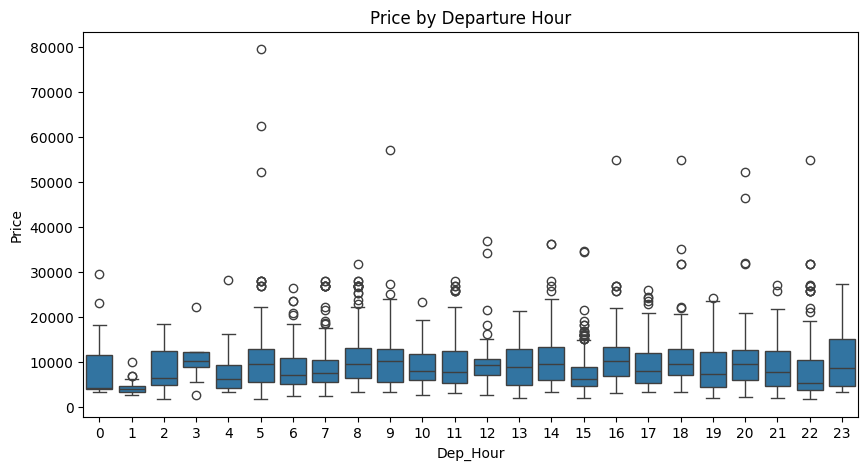

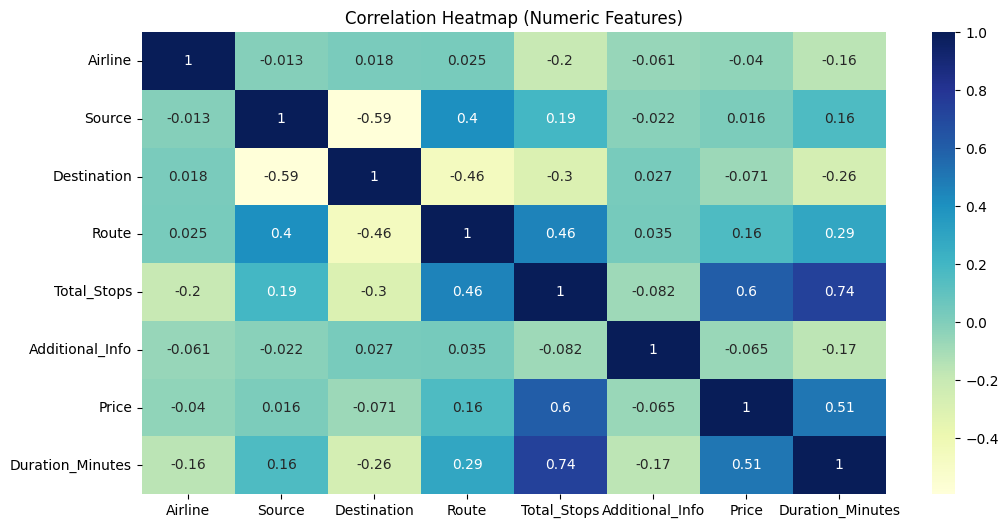

In [8]:
# Price vs Duration
plt.figure(figsize=(8,5))
sns.scatterplot(x='Duration_Minutes', y='Price', data=data_clean, alpha=0.5)
plt.title("Price vs Duration (Minutes)")
plt.show()

# Airline vs Price
plt.figure(figsize=(10,6))
sns.boxplot(x='Airline', y='Price', data=data_clean)
plt.title("Price by Airline")
plt.xticks(rotation=45)
plt.show()

# Price by Departure Hour
plt.figure(figsize=(10,5))
sns.boxplot(x='Dep_Hour', y='Price', data=data_clean)
plt.title("Price by Departure Hour")
plt.show()

numeric_df = data_clean.select_dtypes(include=['int64', 'float64'])

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


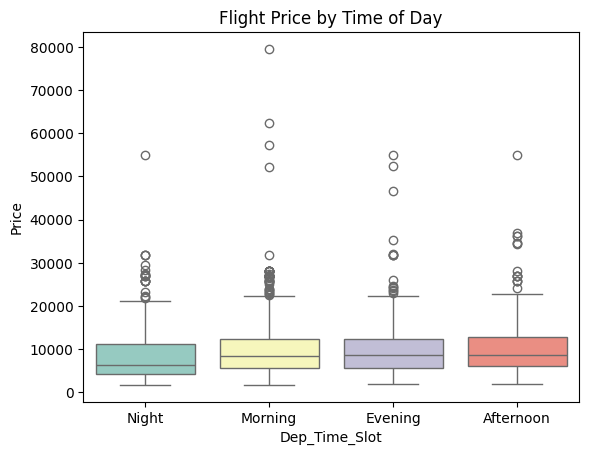

In [9]:
# Time bucket feature
def get_time_slot(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data_clean['Dep_Time_Slot'] = data_clean['Dep_Hour'].apply(get_time_slot)

# Weekend indicator
data_clean['Weekday'] = data_clean['Journey_Date'].dt.dayofweek
data_clean['Weekend_Travel'] = data_clean['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Rush hour flag
data_clean['Rush_Hour'] = data_clean['Dep_Hour'].apply(lambda x: 1 if (7 <= x <= 9 or 17 <= x <= 19) else 0)

# Visualizing new feature
sns.boxplot(x='Dep_Time_Slot', y='Price', data=data_clean, palette='Set3')
plt.title("Flight Price by Time of Day")
plt.show()


In [11]:
print("""
🧠 Insights from the Data:

1. Flights with more stops are generally more expensive, possibly due to increased route complexity.
2. Departure time significantly affects pricing - early morning and evening flights tend to cost more.
3. Airline choice impacts price, as premium airlines charge more than budget options.
4. Duration and price are moderately correlated, especially for longer journeys.
5. Flights on weekends are slightly more expensive, likely due to higher demand.

✈️ Traveler Tips:

- Book mid-week, non-rush-hour flights to save money.
- Consider flights with one stop for potential savings.
- Use early morning or late-night time slots for cheaper pricing.
""")



🧠 Insights from the Data:

1. Flights with more stops are generally more expensive, possibly due to increased route complexity.
2. Departure time significantly affects pricing - early morning and evening flights tend to cost more.
3. Airline choice impacts price, as premium airlines charge more than budget options.
4. Duration and price are moderately correlated, especially for longer journeys.
5. Flights on weekends are slightly more expensive, likely due to higher demand.

✈️ Traveler Tips:

- Book mid-week, non-rush-hour flights to save money.
- Consider flights with one stop for potential savings.
- Use early morning or late-night time slots for cheaper pricing.

